## 讀取 Data，只取第一段5秒，且不 scaling

In [1]:
import os
from pathlib import Path
from utils import data_loader_utils
import itertools 
import pickle

# load X_raw_data.pkl, y_raw_data.pkl
with open("X_raw_data.pkl", "rb") as file:
    X_raw_data = pickle.load(file)

with open("y_raw_data.pkl", "rb") as file:
    y_raw_data = pickle.load(file)

In [2]:
time_lengths = [x.shape[0]//2000 for x in X_raw_data]

In [3]:
num_bad, num_good = [1 if "good" in i else 0 for i in y_raw_data].count(0), [1 if "good" in i else 0 for i in y_raw_data].count(1)
num_bad, num_good

(70, 1632)

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_data(vibration_data, color='b'):
    freq = 2000
    samples_s = len(vibration_data[:, 0]) / freq
    samples = np.linspace(0, samples_s, len(vibration_data[:, 0]))

    # plotting
    plt.figure(figsize=(20, 2))
    plt.plot(samples, vibration_data[:, 0], color)
    plt.ylabel('X-axis Vibration Data')
    plt.xlabel('Time [sec]')
    plt.locator_params(axis='y', nbins=10)
    plt.grid()
    plt.show()
    plt.figure(figsize=(20, 2))
    plt.plot(samples, vibration_data[:, 1], color)
    plt.ylabel('Y-axis Vibration Data')
    plt.xlabel('Time [sec]')
    plt.locator_params(axis='y', nbins=10)
    plt.grid()
    plt.show()
    plt.figure(figsize=(20, 2))
    plt.plot(samples, vibration_data[:, 2], color)
    plt.ylabel('Z-axis Vibration Data')
    plt.xlabel('Time [sec]')
    plt.locator_params(axis='y', nbins=10)
    plt.grid()
    plt.show()

In [5]:
good_indices = [i for i, path in enumerate(y_raw_data) if "good" in path]
bad_indices = [i for i, path in enumerate(y_raw_data) if "bad" in path]

In [6]:
for arr in X_raw_data:
    arr[:, 2] += 1000

In [7]:
import numpy as np

def process_time_series_with_overlap(data, sample_rate=2000, skip_seconds=5, segment_seconds=5, overlap_seconds=2):
    """
    處理 time series data，去除開頭資料並切分成固定長度、具有 overlap 的片段。
    
    :param data: numpy array, shape = (length, 3)
    :param sample_rate: 採樣率, 預設 2000 Hz
    :param skip_seconds: 開頭跳過的秒數, 預設 5 秒
    :param segment_seconds: 每段切分的秒數, 預設 5 秒
    :param overlap_seconds: 每段之間的重疊秒數, 預設 2 秒
    :return: 切分後的資料列表，每個元素為 numpy array
    """
    # 計算需要跳過的資料行數
    skip_rows = skip_seconds * sample_rate
    # 計算每段的行數
    segment_rows = segment_seconds * sample_rate
    # 計算每次移動的步數 (segment_rows - overlap_rows)
    overlap_rows = overlap_seconds * sample_rate
    step_rows = segment_rows - overlap_rows

    # 去掉開頭的資料
    data = data[skip_rows:]
    
    # 切分資料，加入 overlap
    segments = [data[i:i + segment_rows] for i in range(0, len(data) - segment_rows + 1, step_rows)]
    
    # return segments[0:1]
    return segments

In [8]:
X_data = []
y_data = []
SAMPLE_RATE = 2000 # Hz
SKIP_SECONDS = 5 # sec
TIME_LENGTH = 5 # sec
OVERLAP_SECONDS = 2 # sec
# TIME_LENGTH = 10 # sec
# 
for i in range(len(X_raw_data)):
    X_data.extend(process_time_series_with_overlap(X_raw_data[i], SAMPLE_RATE, SKIP_SECONDS, TIME_LENGTH, OVERLAP_SECONDS))
    if 'good' in y_raw_data[i]:
        y_data.extend([0] * len(process_time_series_with_overlap(X_raw_data[i], SAMPLE_RATE, SKIP_SECONDS, TIME_LENGTH, OVERLAP_SECONDS)))
    else:
        y_data.extend([1] * len(process_time_series_with_overlap(X_raw_data[i], SAMPLE_RATE, SKIP_SECONDS, TIME_LENGTH, OVERLAP_SECONDS)))

In [9]:
del X_raw_data

In [10]:
X_data1 = np.array(X_data)

In [11]:
X_data_abs = np.abs(X_data1)
# X_data_abs[:4]

In [12]:
x_abs_max, y_abs_max, z_abs_max = X_data_abs[:,:,0].max(), X_data_abs[:,:,1].max(), X_data_abs[:,:,2].max()
print(x_abs_max, y_abs_max, z_abs_max)

9234.0 6552.0 4090.0


## no scaling

In [13]:
# for i,m_i in enumerate([x_abs_max, y_abs_max, z_abs_max]):
#     X_data1[:,:,i] = X_data1[:,:,i]/m_i

In [14]:
good_indices = [index for index, value in enumerate(y_data) if value == 0]
bad_indices = [index for index, value in enumerate(y_data) if value == 1]

## 取 z-axis time domain

In [15]:
X_good = X_data1[good_indices][:,:,-1]
X_good.shape

(24258, 10000)

In [16]:
X_bad = X_data1[bad_indices][:,:,-1]
X_bad.shape

(735, 10000)

In [17]:
SEED = 42

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

# 劃分正常資料為訓練集與測試集
X_good_train, X_good_test = train_test_split(X_good, test_size= len(X_bad) / len(X_good) * 4, random_state=SEED)

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

tf.random.set_seed(SEED) 
np.random.seed(SEED)

# AutoEncoder 模型
input_dim = X_good_train.shape[1]
encoding_dim = 128

autoencoder = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(512, activation='relu'),
    layers.Dense(encoding_dim, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(input_dim, activation='linear')
])

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

2025-01-13 09:22:35.620518: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-13 09:22:36.443571: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2025-01-13 09:22:36.443704: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2025-01-13 09:22:36.443714: W tensorflow/compiler/tf2tensorrt/util

2025-01-13 09:22:37.133117: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-13 09:22:37.148764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-13 09:22:37.149053: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-13 09:22:37.149621: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               5120512   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 512)               66048     
                                                                 
 dense_3 (Dense)             (None, 10000)             5130000   
                                                                 
Total params: 10,382,224
Trainable params: 10,382,224
Non-trainable params: 0
_________________________________________________________________


least one NUMA node, so returning NUMA node zero
2025-01-13 09:22:37.150795: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-13 09:22:37.151005: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-13 09:22:37.843898: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-13 09:22:37.844277: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-13 09:22:37

In [20]:
# 計算重建誤差 (MSE) 作為異常分數
def calculate_reconstruction_error(model, data):
    reconstructed = model.predict(data)
    print(data.shape)
    # print(reconstructed.shape)
    mse = np.mean(np.square(data - reconstructed), axis=1)
    return mse

## Before training

2025-01-13 09:22:39.067724: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 147000000 exceeds 10% of free system memory.
2025-01-13 09:22:39.260321: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 147000000 exceeds 10% of free system memory.


115/115 [==============================] - 1s 1ms/step


2025-01-13 09:22:40.080004: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 147000000 exceeds 10% of free system memory.


(3675, 10000)
AUC: 0.7950


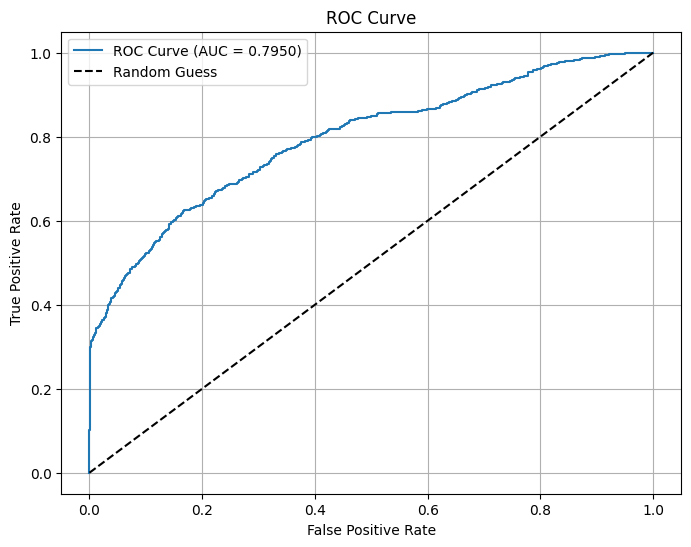

Optimal Threshold: 63556.0966


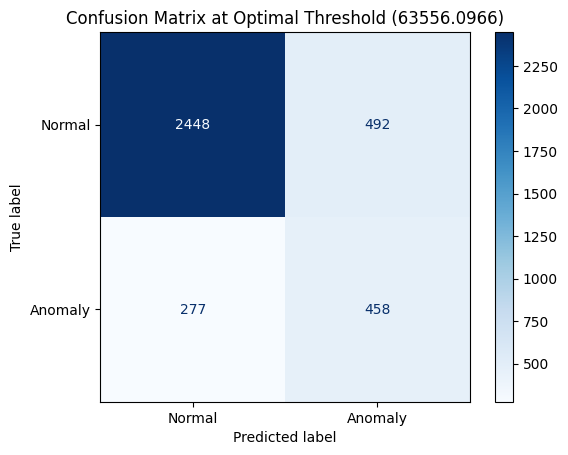

TPR (True Positive Rate): 0.6231
FPR (False Positive Rate): 0.1673
Precision: 0.4821
Recall: 0.6231


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# 假設你已經有 X_good_test 和 X_bad
X_test = np.concatenate([X_good_test, X_bad])  # 組合測試集
X_test_labels = np.concatenate([np.zeros(len(X_good_test)), np.ones(len(X_bad))])  # 標註正常和異常資料

# 計算重建誤差
re_error_X_test = calculate_reconstruction_error(autoencoder, X_test)

# 計算 ROC 曲線的 FPR, TPR 和閾值
fpr, tpr, thresholds = roc_curve(X_test_labels, re_error_X_test)

# 計算 AUC
auc = roc_auc_score(X_test_labels, re_error_X_test)
print(f"AUC: {auc:.4f}")

# 繪製 ROC 曲線
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.title("ROC Curve")
plt.show()

# 找到最佳閾值，通常是 ROC 曲線中最靠近 (0, 1) 點的閾值
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.4f}")

# 使用最佳閾值將異常分數轉換為二元分類結果
predictions = (re_error_X_test > optimal_threshold).astype(int)

# 計算混淆矩陣
cm = confusion_matrix(X_test_labels, predictions)

# 可視化混淆矩陣
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix at Optimal Threshold ({optimal_threshold:.4f})")
plt.show()

# # 打印混淆矩陣數值
# print("Confusion Matrix:")
# print(cm)

# 取得混淆矩陣中的各項數值
TN, FP, FN, TP = cm.ravel()

# 計算 TPR、FPR、Precision 和 Recall
TPR = TP / (TP + FN)  # True Positive Rate
FPR = FP / (FP + TN)  # False Positive Rate
Precision = TP / (TP + FP)  # Precision
Recall = TP / (TP + FN)  # Recall

# 打印指標
print(f"TPR (True Positive Rate): {TPR:.4f}")
print(f"FPR (False Positive Rate): {FPR:.4f}")
print(f"Precision: {Precision:.4f}")
print(f"Recall: {Recall:.4f}")

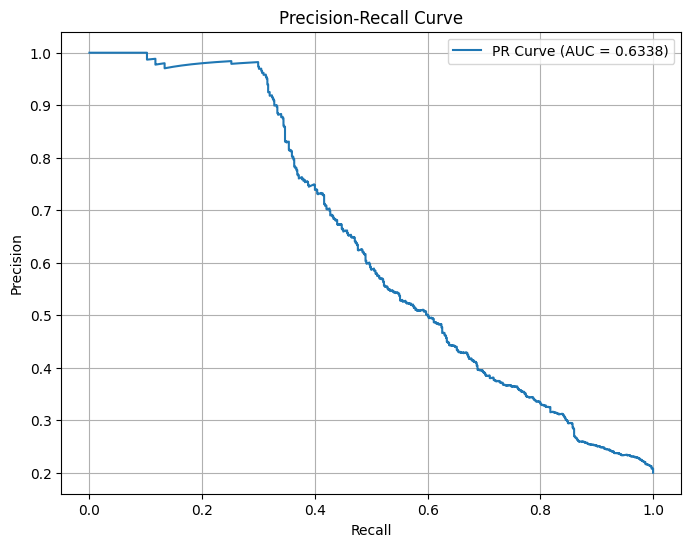

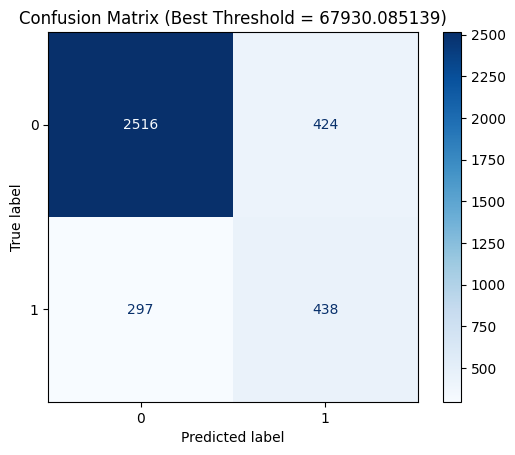

TPR (True Positive Rate): 0.5959
FPR (False Positive Rate): 0.1442
Precision: 0.5081
Recall: 0.5959


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# 假設你已經有 X_test_labels 和 re_error_X_test
precision, recall, thresholds = precision_recall_curve(X_test_labels, re_error_X_test)

# 計算 AUC (Precision-Recall AUC)
pr_auc = auc(recall, precision)

# 繪製 Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.title("Precision-Recall Curve")
plt.show()

# 計算 F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)

# 找到最佳閾值 (最佳 F1 score 對應的閾值)
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]

# 使用最佳閾值來計算預測類別
y_pred = (re_error_X_test >= best_threshold).astype(int)

# 計算混淆矩陣
cm = confusion_matrix(X_test_labels, y_pred)

# 可視化混淆矩陣
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix (Best Threshold = {best_threshold:.6f})")
plt.show()

# # 打印混淆矩陣數值
# print(f"Confusion Matrix at Best Threshold ({best_threshold:.2f}):")
# print(cm)

# 取得混淆矩陣中的各項數值
TN, FP, FN, TP = cm.ravel()

# 計算 TPR、FPR、Precision 和 Recall
TPR = TP / (TP + FN)  # True Positive Rate
FPR = FP / (FP + TN)  # False Positive Rate
Precision = TP / (TP + FP)  # Precision
Recall = TP / (TP + FN)  # Recall

# 打印指標
print(f"TPR (True Positive Rate): {TPR:.4f}")
print(f"FPR (False Positive Rate): {FPR:.4f}")
print(f"Precision: {Precision:.4f}")
print(f"Recall: {Recall:.4f}")

## Training 1

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

# 定義 Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',  # 監控的指標（可以是 'val_loss', 'loss', 或其他 metric）
    patience=20,          # 容忍幾個 epoch 無改善
    verbose=1,           # 是否顯示早停的訊息
    restore_best_weights=True  # 是否恢復為最佳權重
)

In [24]:
# 訓練 AutoEncoder (僅使用正常資料)
# history = autoencoder.fit(X_good, X_good, epochs=300, batch_size=32, shuffle=True, validation_split=0.2)
# 加入 Early Stopping 回調並訓練模型
history = autoencoder.fit(
    X_good_train, 
    X_good_train, 
    epochs=100, 
    batch_size=16, 
    shuffle=True, 
    validation_split=0.2, 
    callbacks=[early_stop]  # 加入 Early Stopping
)

2025-01-13 09:22:43.380514: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 682160000 exceeds 10% of free system memory.
2025-01-13 09:22:44.885097: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 682160000 exceeds 10% of free system memory.


Epoch 1/100


2025-01-13 09:22:47.509182: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x33395170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-13 09:22:47.509252: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): GRID P40-24Q, Compute Capability 6.1
2025-01-13 09:22:47.515274: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-13 09:22:47.666269: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1066/1066 [==============================] - 7s 5ms/step - loss: 31546.1641 - val_loss: 27477.3730
Epoch 2/100
1066/1066 [==============================] - 4s 4ms/step - loss: 26352.2812 - val_loss: 25381.0859
Epoch 3/100
1066/1066 [==============================] - 4s 4ms/step - loss: 24574.1582 - val_loss: 24404.7930
Epoch 4/100
1066/1066 [==============================] - 4s 4ms/step - loss: 23877.8359 - val_loss: 24040.0215
Epoch 5/100
1066/1066 [==============================] - 4s 4ms/step - loss: 23525.6641 - val_loss: 23756.7324
Epoch 6/100
1066/1066 [==============================] - 4s 4ms/step - loss: 23271.7324 - val_loss: 23839.2852
Epoch 7/100
1066/1066 [==============================] - 4s 4ms/step - loss: 23106.8770 - val_loss: 23243.9375
Epoch 8/100
1066/1066 [==============================] - 4s 4ms/step - loss: 22984.5684 - val_loss: 23583.5000
Epoch 9/100
1066/1066 [==============================] - 4s 4ms/step - loss: 22731.1602 - val_loss: 23235.1816
Epoch 10/100


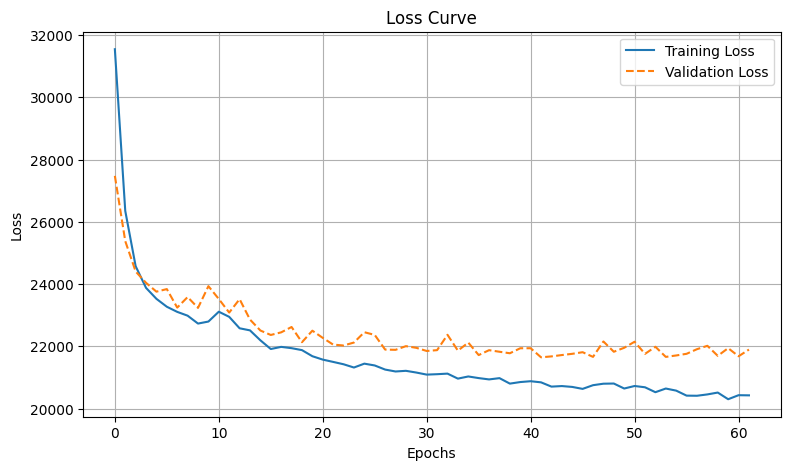

In [25]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']       # 訓練損失
val_loss = history.history['val_loss']    # 驗證損失

# 繪製訓練與驗證損失
plt.figure(figsize=(9, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
len(X_good_test), len(X_bad)

(2940, 735)

115/115 [==============================] - 0s 1ms/step
(3675, 10000)
AUC: 0.8766


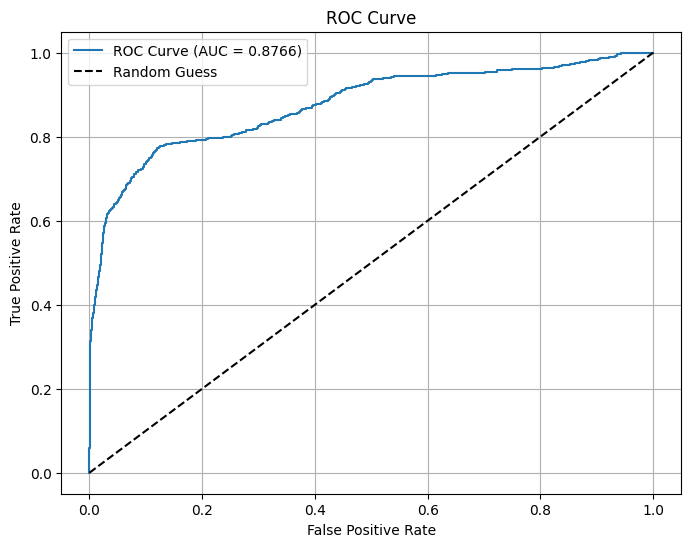

Optimal Threshold: 33709.6636


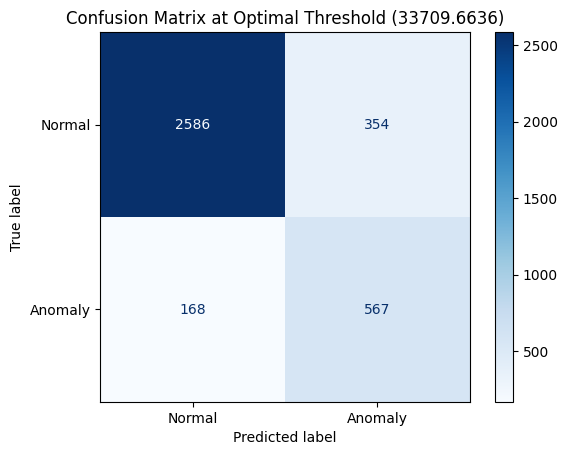

TPR (True Positive Rate): 0.7714
FPR (False Positive Rate): 0.1204
Precision: 0.6156
Recall: 0.7714


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# 假設你已經有 X_good_test 和 X_bad
X_test = np.concatenate([X_good_test, X_bad])  # 組合測試集
X_test_labels = np.concatenate([np.zeros(len(X_good_test)), np.ones(len(X_bad))])  # 標註正常和異常資料

# 計算重建誤差
re_error_X_test = calculate_reconstruction_error(autoencoder, X_test)

# 計算 ROC 曲線的 FPR, TPR 和閾值
fpr, tpr, thresholds = roc_curve(X_test_labels, re_error_X_test)

# 計算 AUC
auc = roc_auc_score(X_test_labels, re_error_X_test)
print(f"AUC: {auc:.4f}")

# 繪製 ROC 曲線
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.title("ROC Curve")
plt.show()

# 找到最佳閾值，通常是 ROC 曲線中最靠近 (0, 1) 點的閾值
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.4f}")

# 使用最佳閾值將異常分數轉換為二元分類結果
predictions = (re_error_X_test > optimal_threshold).astype(int)

# 計算混淆矩陣
cm = confusion_matrix(X_test_labels, predictions)

# 可視化混淆矩陣
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix at Optimal Threshold ({optimal_threshold:.4f})")
plt.show()

# # 打印混淆矩陣數值
# print("Confusion Matrix:")
# print(cm)
# 取得混淆矩陣中的各項數值
TN, FP, FN, TP = cm.ravel()

# 計算 TPR、FPR、Precision 和 Recall
TPR = TP / (TP + FN)  # True Positive Rate
FPR = FP / (FP + TN)  # False Positive Rate
Precision = TP / (TP + FP)  # Precision
Recall = TP / (TP + FN)  # Recall

# 打印指標
print(f"TPR (True Positive Rate): {TPR:.4f}")
print(f"FPR (False Positive Rate): {FPR:.4f}")
print(f"Precision: {Precision:.4f}")
print(f"Recall: {Recall:.4f}")

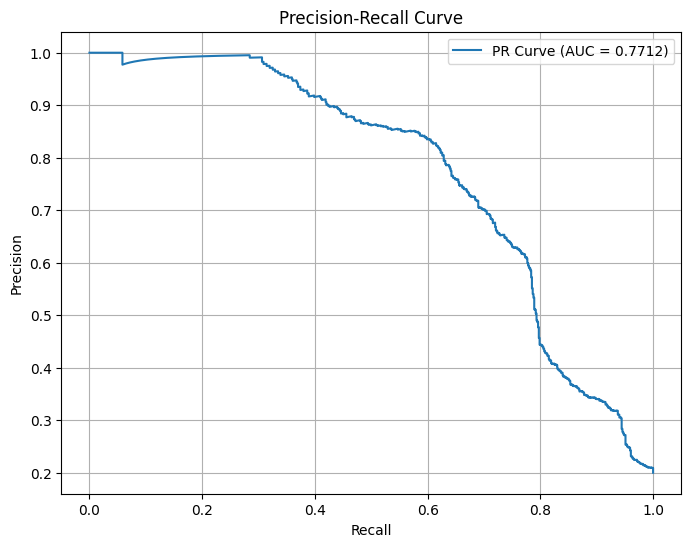

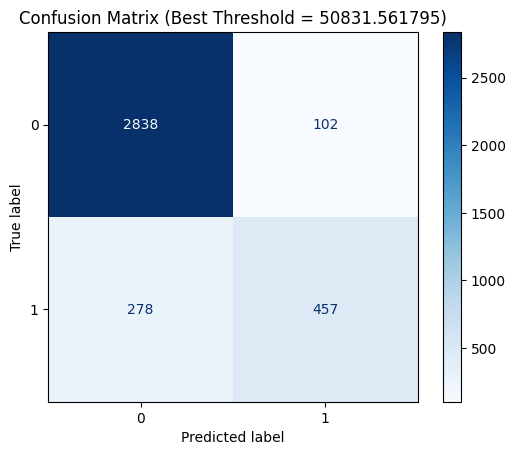

TPR (True Positive Rate): 0.6218
FPR (False Positive Rate): 0.0347
Precision: 0.8175
Recall: 0.6218


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# 假設你已經有 X_test_labels 和 re_error_X_test
precision, recall, thresholds = precision_recall_curve(X_test_labels, re_error_X_test)

# 計算 AUC (Precision-Recall AUC)
pr_auc = auc(recall, precision)

# 繪製 Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.title("Precision-Recall Curve")
plt.show()

# 計算 F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)

# 找到最佳閾值 (最佳 F1 score 對應的閾值)
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]

# 使用最佳閾值來計算預測類別
y_pred = (re_error_X_test >= best_threshold).astype(int)

# 計算混淆矩陣
cm = confusion_matrix(X_test_labels, y_pred)

# 可視化混淆矩陣
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix (Best Threshold = {best_threshold:.6f})")
plt.show()

# # 打印混淆矩陣數值
# print(f"Confusion Matrix at Best Threshold ({best_threshold:.2f}):")
# print(cm)
# 取得混淆矩陣中的各項數值
TN, FP, FN, TP = cm.ravel()

# 計算 TPR、FPR、Precision 和 Recall
TPR = TP / (TP + FN)  # True Positive Rate
FPR = FP / (FP + TN)  # False Positive Rate
Precision = TP / (TP + FP)  # Precision
Recall = TP / (TP + FN)  # Recall

# 打印指標
print(f"TPR (True Positive Rate): {TPR:.4f}")
print(f"FPR (False Positive Rate): {FPR:.4f}")
print(f"Precision: {Precision:.4f}")
print(f"Recall: {Recall:.4f}")

## Training 2

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(SEED) 
np.random.seed(SEED)

# AutoEncoder 模型
input_dim = X_good_train.shape[1]
encoding_dim = 128

autoencoder = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(512, activation='relu'),
    layers.Dense(encoding_dim, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(input_dim, activation='linear')
])

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# 定義 Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',  # 監控的指標（可以是 'val_loss', 'loss', 或其他 metric）
    patience=20,          # 容忍幾個 epoch 無改善
    verbose=1,           # 是否顯示早停的訊息
    restore_best_weights=True  # 是否恢復為最佳權重
)

# 訓練 AutoEncoder (僅使用正常資料)
# history = autoencoder.fit(X_good, X_good, epochs=300, batch_size=32, shuffle=True, validation_split=0.2)
# 加入 Early Stopping 回調並訓練模型
history = autoencoder.fit(
    X_good_train, 
    X_good_train, 
    epochs=100, 
    batch_size=16, 
    shuffle=True, 
    validation_split=0.2, 
    callbacks=[early_stop]  # 加入 Early Stopping
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               5120512   
                                                                 
 dense_5 (Dense)             (None, 128)               65664     
                                                                 
 dense_6 (Dense)             (None, 512)               66048     
                                                                 
 dense_7 (Dense)             (None, 10000)             5130000   
                                                                 
Total params: 10,382,224
Trainable params: 10,382,224
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
1066/1066 [==============================] - 6s 5ms/step - loss: 31399.9316 - val_loss: 27359.1348
Epoch 2/100
1066/1066 [==============================] - 4s 4ms/step - loss: 25811.3574 - val_loss: 24861.9863
Epoch 3/100
1066/1066 [==============================] - 4s 4ms/step - loss: 24219.3047 - val_loss: 24315.4844
Epoch 4/100
1066/1066 [==============================] - 4s 4ms/step - loss: 23609.8652 - val_loss: 23672.0156
Epoch 5/100
1066/1066 [==============================] - 4s 4ms/step - loss: 23331.3672 - val_loss: 23437.2285
Epoch 6/100
1066/1066 [==============================] - 4s 4ms/step - loss: 23106.1055 - val_loss: 23267.7441
Epoch 7/100
1066/1066 [==============================] - 4s 4ms/step - loss: 22804.7773 - val_loss: 22947.2617
Epoch 8/100
1066/1066 [==============================] - 4s 4ms/step - loss: 22591.5684 - val_loss: 23067.9316
Epoch 9/100
1066/1066 [==============================] - 4s 4ms/step - loss: 22465.7637 - val_loss: 22881.7520
E

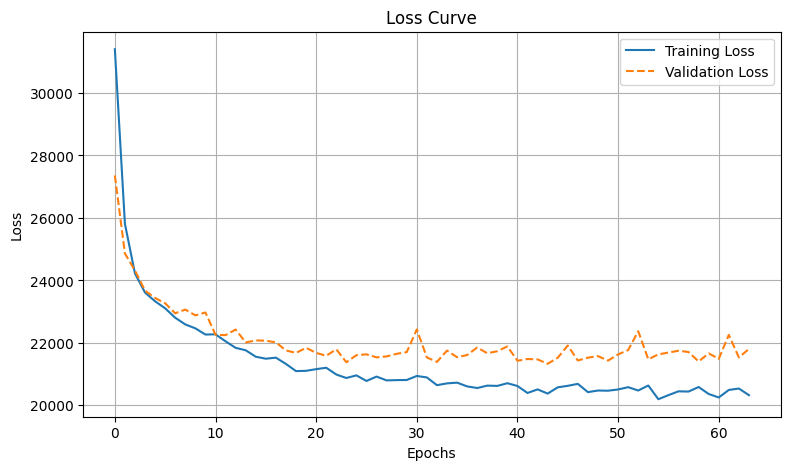

In [30]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']       # 訓練損失
val_loss = history.history['val_loss']    # 驗證損失

# 繪製訓練與驗證損失
plt.figure(figsize=(9, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

115/115 [==============================] - 0s 1ms/step
(3675, 10000)
AUC: 0.8678


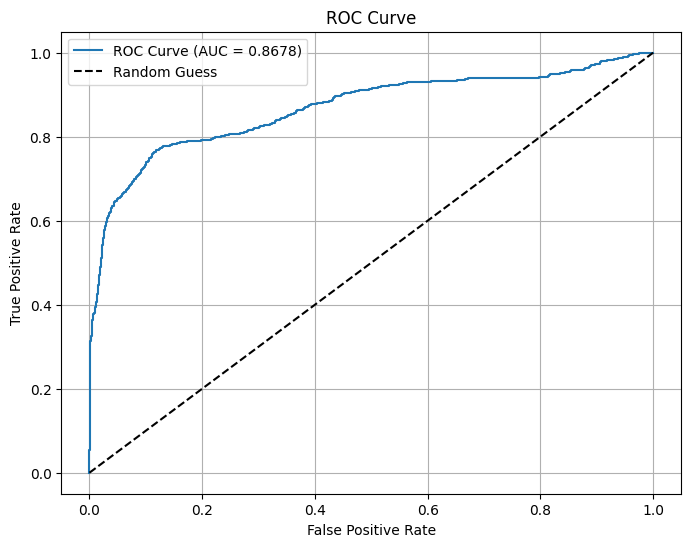

Optimal Threshold: 33393.6747


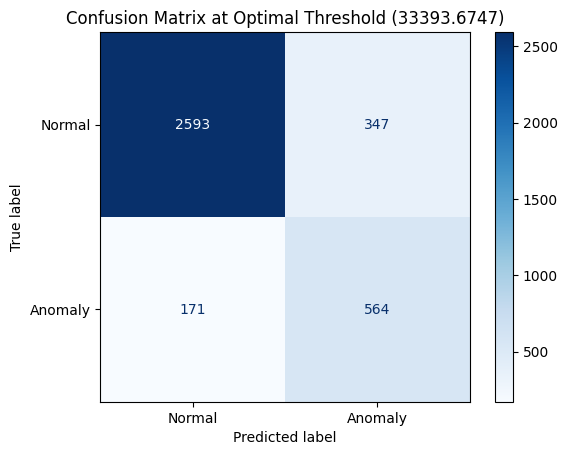

TPR (True Positive Rate): 0.7673
FPR (False Positive Rate): 0.1180
Precision: 0.6191
Recall: 0.7673


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# 假設你已經有 X_good_test 和 X_bad
X_test = np.concatenate([X_good_test, X_bad])  # 組合測試集
X_test_labels = np.concatenate([np.zeros(len(X_good_test)), np.ones(len(X_bad))])  # 標註正常和異常資料

# 計算重建誤差
re_error_X_test = calculate_reconstruction_error(autoencoder, X_test)

# 計算 ROC 曲線的 FPR, TPR 和閾值
fpr, tpr, thresholds = roc_curve(X_test_labels, re_error_X_test)

# 計算 AUC
auc = roc_auc_score(X_test_labels, re_error_X_test)
print(f"AUC: {auc:.4f}")

# 繪製 ROC 曲線
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.title("ROC Curve")
plt.show()

# 找到最佳閾值，通常是 ROC 曲線中最靠近 (0, 1) 點的閾值
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.4f}")

# 使用最佳閾值將異常分數轉換為二元分類結果
predictions = (re_error_X_test > optimal_threshold).astype(int)

# 計算混淆矩陣
cm = confusion_matrix(X_test_labels, predictions)

# 可視化混淆矩陣
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix at Optimal Threshold ({optimal_threshold:.4f})")
plt.show()

# # 打印混淆矩陣數值
# print("Confusion Matrix:")
# print(cm)
# 取得混淆矩陣中的各項數值
TN, FP, FN, TP = cm.ravel()

# 計算 TPR、FPR、Precision 和 Recall
TPR = TP / (TP + FN)  # True Positive Rate
FPR = FP / (FP + TN)  # False Positive Rate
Precision = TP / (TP + FP)  # Precision
Recall = TP / (TP + FN)  # Recall

# 打印指標
print(f"TPR (True Positive Rate): {TPR:.4f}")
print(f"FPR (False Positive Rate): {FPR:.4f}")
print(f"Precision: {Precision:.4f}")
print(f"Recall: {Recall:.4f}")

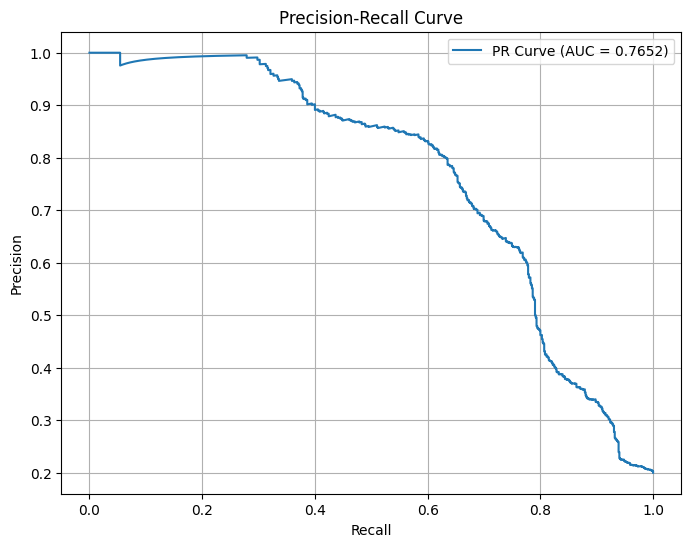

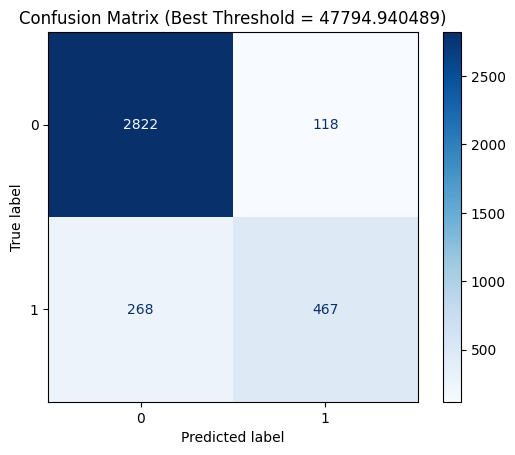

TPR (True Positive Rate): 0.6354
FPR (False Positive Rate): 0.0401
Precision: 0.7983
Recall: 0.6354


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# 假設你已經有 X_test_labels 和 re_error_X_test
precision, recall, thresholds = precision_recall_curve(X_test_labels, re_error_X_test)

# 計算 AUC (Precision-Recall AUC)
pr_auc = auc(recall, precision)

# 繪製 Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.title("Precision-Recall Curve")
plt.show()

# 計算 F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)

# 找到最佳閾值 (最佳 F1 score 對應的閾值)
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]

# 使用最佳閾值來計算預測類別
y_pred = (re_error_X_test >= best_threshold).astype(int)

# 計算混淆矩陣
cm = confusion_matrix(X_test_labels, y_pred)

# 可視化混淆矩陣
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix (Best Threshold = {best_threshold:.6f})")
plt.show()

# # 打印混淆矩陣數值
# print(f"Confusion Matrix at Best Threshold ({best_threshold:.2f}):")
# print(cm)
# 取得混淆矩陣中的各項數值
TN, FP, FN, TP = cm.ravel()

# 計算 TPR、FPR、Precision 和 Recall
TPR = TP / (TP + FN)  # True Positive Rate
FPR = FP / (FP + TN)  # False Positive Rate
Precision = TP / (TP + FP)  # Precision
Recall = TP / (TP + FN)  # Recall

# 打印指標
print(f"TPR (True Positive Rate): {TPR:.4f}")
print(f"FPR (False Positive Rate): {FPR:.4f}")
print(f"Precision: {Precision:.4f}")
print(f"Recall: {Recall:.4f}")

115/115 [==============================] - 0s 1ms/step
(3675, 10000)
AUC: 0.8678


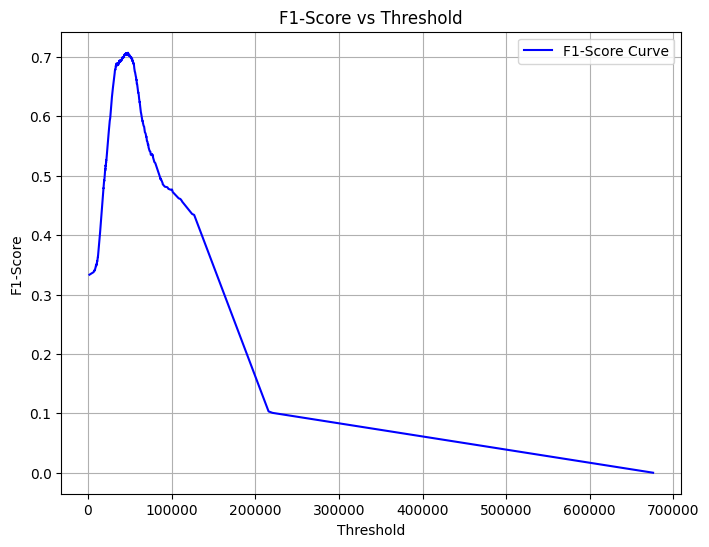

Best F1-Score: 0.7071 at Threshold: 47904.5934


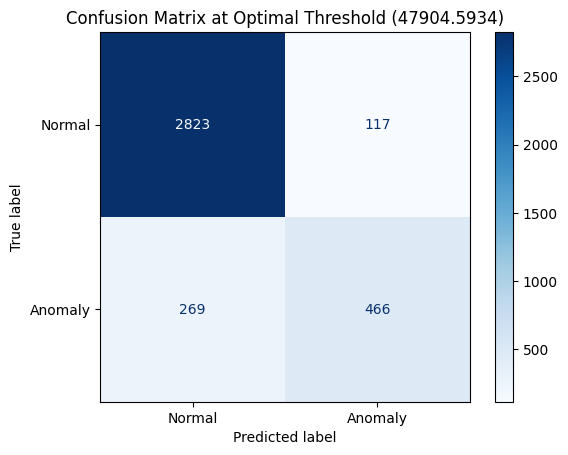

TPR (True Positive Rate): 0.6340
FPR (False Positive Rate): 0.0398
Precision: 0.7993
Recall: 0.6340
F1-Score (at Optimal Threshold): 0.7071


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, f1_score

# 假設你已經有 X_good_test 和 X_bad
X_test = np.concatenate([X_good_test, X_bad])  # 組合測試集
X_test_labels = np.concatenate([np.zeros(len(X_good_test)), np.ones(len(X_bad))])  # 標註正常和異常資料

# 計算重建誤差
re_error_X_test = calculate_reconstruction_error(autoencoder, X_test)

# 計算 ROC 曲線的 FPR, TPR 和閾值
fpr, tpr, thresholds = roc_curve(X_test_labels, re_error_X_test)

# 計算 AUC
auc = roc_auc_score(X_test_labels, re_error_X_test)
print(f"AUC: {auc:.4f}")

# 計算每個閾值下的 F1 分數
f1_scores = []
for threshold in thresholds:
    predictions = (re_error_X_test > threshold).astype(int)
    f1 = f1_score(X_test_labels, predictions)
    f1_scores.append(f1)

# 繪製 F1-Score 曲線
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores, label="F1-Score Curve", color="blue")
plt.xlabel("Threshold")
plt.ylabel("F1-Score")
plt.title("F1-Score vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

# 找到最佳閾值
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
best_f1_score = f1_scores[optimal_idx]
print(f"Best F1-Score: {best_f1_score:.4f} at Threshold: {optimal_threshold:.4f}")

# 使用最佳閾值將異常分數轉換為二元分類結果
predictions = (re_error_X_test > optimal_threshold).astype(int)

# 計算混淆矩陣
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(X_test_labels, predictions)

# 可視化混淆矩陣
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix at Optimal Threshold ({optimal_threshold:.4f})")
plt.show()

# 取得混淆矩陣中的各項數值
TN, FP, FN, TP = cm.ravel()

# 計算 TPR、FPR、Precision、Recall 和 F1-Score
TPR = TP / (TP + FN)  # True Positive Rate
FPR = FP / (FP + TN)  # False Positive Rate
Precision = TP / (TP + FP)  # Precision
Recall = TP / (TP + FN)  # Recall
final_f1_score = 2 * (Precision * Recall) / (Precision + Recall)  # F1-Score

# 打印指標
print(f"TPR (True Positive Rate): {TPR:.4f}")
print(f"FPR (False Positive Rate): {FPR:.4f}")
print(f"Precision: {Precision:.4f}")
print(f"Recall: {Recall:.4f}")
print(f"F1-Score (at Optimal Threshold): {final_f1_score:.4f}")

## Final